<a href="https://colab.research.google.com/github/jrakhshanda/Text-Mining/blob/main/Classification_RCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -m spacy download en_core_web_sm
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz
!pip install scispacy
from IPython.display import clear_output
clear_output() #for clarity

In [7]:
#general importation
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import time
import random
import matplotlib.pyplot as plt
%matplotlib inline

#Natural Language processing
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model, svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, recall_score

import spacy
import scispacy
import en_core_sci_lg

from google.colab import files
import csv
from zipfile import ZipFile

from IPython.display import clear_output
clear_output() #for clarity


In [8]:
train = pd.read_csv('/content/drive/MyDrive/PubMed_RCT/train.zip', compression='zip', header=0)
dev = pd.read_csv('/content/drive/MyDrive/PubMed_RCT/dev.csv')
test = pd.read_csv('/content/drive/MyDrive/PubMed_RCT/test.csv')
test = pd.concat([dev, test], axis=0)

In [9]:
train = train.dropna()
train = train.astype('str')
train.columns = ['Label', 'Text']

In [10]:
labels = sorted(train['Label'].unique())
train.head()

,Label,Text
0,BACKGROUND,The emergence of HIV as a chronic condition me...
1,BACKGROUND,This paper describes the design and evaluation...
2,METHODS,This study is designed as a randomised control...
3,METHODS,The intervention group will participate in the...
4,METHODS,The program is based on self-efficacy theory a...


In [11]:
X_train,y_train = train['Text'], train['Label']
X_test,y_test = test['Text'], test['Label']

### Visualization of the dataset

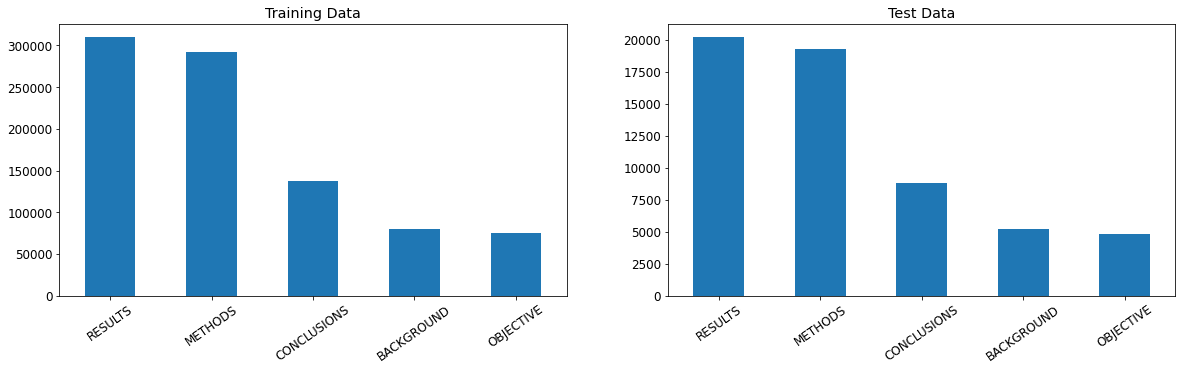

In [124]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
train["Label"].value_counts().plot(kind='bar')
plt.xticks(rotation=35)
plt.title("Training Data");

plt.subplot(1, 2, 2)
test["Label"].value_counts().plot(kind='bar')
plt.xticks(rotation=35)
plt.title("Test Data");

plt.show()

In [103]:
lst1 = [train.Label[train.Label == 'BACKGROUNG'].count(),
        train.Label[train.Label == 'CONCLUSION'].count(),
        train.Label[train.Label == 'METHOD'].count(),
        train.Label[train.Label == 'OBJECTIVE'].count(),
        train.Label[train.Label == 'RESULTS'].count()]

lst2 = [test.Label[test.Label == 'RESULTS'].count(),
        test.Label[test.Label == 'METHOD'].count(),
        test.Label[test.Label == 'CONCLUSION'].count(),
        test.Label[test.Label == 'BACKGROUNG'].count(),
        test.Label[test.Label == 'OBJECTIVE'].count()]

lst3 = [dev.Label[dev.Label == 'RESULTS'].count(),
        dev.Label[dev.Label == 'METHOD'].count(),
        dev.Label[dev.Label == 'CONCLUSION'].count(),
        dev.Label[dev.Label == 'BACKGROUNG'].count(),
        dev.Label[dev.Label == 'OBJECTIVE'].count()]
        

## Word Clouds

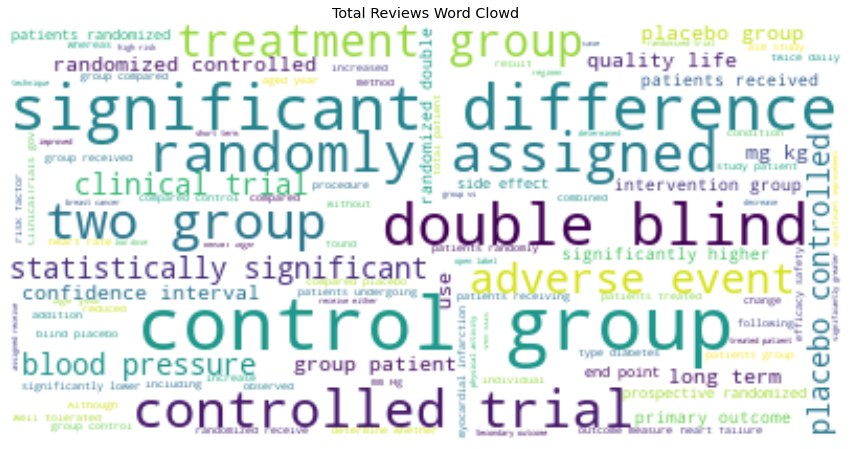

In [107]:
from wordcloud import  WordCloud, STOPWORDS, ImageColorGenerator
 
# Get stopwords from wordcloud library
stopwords = set(STOPWORDS)
 
# Add some extra words ad hoc for our purpose
app_words = ['app', 'apps', 'application', 'game','http','now','im','say','go','didnt','going','got',
             'will','ve','make','back','one','today','work','gonna','day','time','much','home','didn',
             'look','right','even','thing','getting']
stopwords.update(app_words)
df = train
# join all reviews
text = " ".join(review for review in df.Text)
 
# Generate the image
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100).generate(text)
 
# visualize the image
fig=plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Total Reviews Word Clowd')
plt.show()

### Word Clouds for Labels

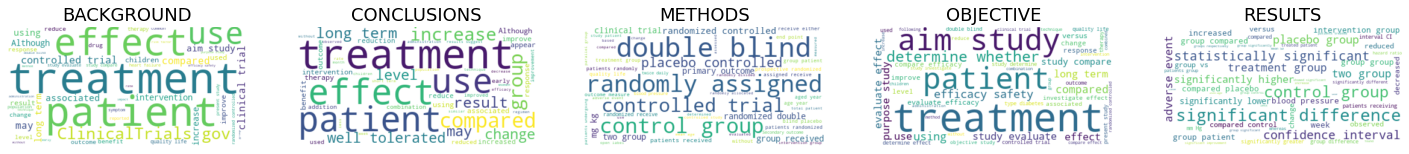

In [110]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(25,8))
for i , label in enumerate(labels):
  text = " ".join(review for review in train.Text[train.Label == label])
  word_cloud = WordCloud(stopwords=stopwords, background_color="white", max_words=50).generate(text)
  plt.subplot(1, len(labels), i+1)
  plt.imshow(word_cloud, interpolation='bilinear', alpha=1)
  plt.axis("off")
  plt.title(label)

# Classification Methods

### Näaive Bayes Classifier

In [16]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

**Classification report using tf-idf Vectorizer**

In [126]:
pipe1 = Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('multinomialNB', MultinomialNB())])
pipe1.fit(X_train, y_train)
print('Accuracy of the model on training data using tf-idf Vectorizer:',pipe1.score(X_train,y_train))
print('Accuracy of the model on test data using tf-idf Vectorizer:',pipe1.score(X_test,y_test))
nb_pred1 = pipe1.predict(X_test)

Accuracy of the model on training data using tf-idf Vectorizer: 0.7707871021979655
Accuracy of the model on test data using tf-idf Vectorizer: 0.7516645271715875


In [128]:
print(classification_report(y_test,nb_pred1))

              precision    recall  f1-score   support

  BACKGROUND       0.66      0.34      0.45      5238
 CONCLUSIONS       0.62      0.70      0.66      8822
     METHODS       0.77      0.88      0.82     19310
   OBJECTIVE       0.74      0.36      0.48      4802
     RESULTS       0.80      0.85      0.83     20253

    accuracy                           0.75     58425
   macro avg       0.72      0.63      0.65     58425
weighted avg       0.75      0.75      0.74     58425



**Classification report using CountVectorizer (BOW)**

In [129]:
pipe2 = Pipeline(steps=[('vectorizer', CountVectorizer()), ('multinomialNB', MultinomialNB())])
pipe2.fit(X_train, y_train)
print('Accuracy of the model on training data using bag-of-words Vectorizer model:',pipe2.score(X_train,y_train))
print('Accuracy of the model on test data using bag-of-words Vectorizer model:',pipe2.score(X_test,y_test))
nb_pred2 = pipe2.predict(X_test)

Accuracy of the model on training data using bag-of-words Vectorizer model: 0.7951893161499772
Accuracy of the model on test data using bag-of-words Vectorizer model: 0.7759007274283269


In [130]:
print(classification_report(y_test,nb_pred2))

              precision    recall  f1-score   support

  BACKGROUND       0.57      0.57      0.57      5238
 CONCLUSIONS       0.65      0.75      0.70      8822
     METHODS       0.85      0.86      0.85     19310
   OBJECTIVE       0.61      0.63      0.62      4802
     RESULTS       0.87      0.79      0.83     20253

    accuracy                           0.78     58425
   macro avg       0.71      0.72      0.72     58425
weighted avg       0.78      0.78      0.78     58425



Count Vectorizer is performing better on this dataset as compare to TF-IDF vectorizer but still F1-Score is not good enough so we will try to use ither classification methods. \newline

We have applied two different kinds of vectorizers (tf-idf & bag-of-words model) to vectorize the speech data. In order to classify the distribution of speeches over different parties we are using multinomial Naive Bayes classifier. We have seen that accuracy of our model in the case of tf-idf vectorizer is very poor as compare to BoW model but this model is also not working good on test data. This is because our data is not balanced properly. we have more data for some parties and very few speeches for some parties. This problem can be handeled by creating a balanced datset or by asssigning weights to all classes while classifying.



### Simple BASELINE Approach

Evaluation metrics such as accuracy should not be understood as absolute measures of performance, but should be used only to compare different classifiers. When other classifiers are not available, a simple baseline is a classifier that generates predictions by random sampling, respecting the training set’s class distribution. This baseline is implemented by the class [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html). What is the performance of the random baseline on the test data?

In [15]:
from sklearn.dummy import DummyClassifier
pipe3 = Pipeline([('vectorizer', CountVectorizer()), ('dummy',DummyClassifier(strategy="most_frequent"))])
pipe3.fit(X_train, y_train)
dummy_pred = pipe3.predict(X_test)

In [17]:
print(classification_report(y_test,dummy_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

  BACKGROUND       0.00      0.00      0.00      5238
 CONCLUSIONS       0.00      0.00      0.00      8822
     METHODS       0.00      0.00      0.00     19310
   OBJECTIVE       0.00      0.00      0.00      4802
     RESULTS       0.35      1.00      0.51     20253

    accuracy                           0.35     58425
   macro avg       0.07      0.20      0.10     58425
weighted avg       0.12      0.35      0.18     58425



In [18]:
print("Accuracy on training data:",pipe3.score(X_train,y_train))
print("Accuracy on test data:",pipe3.score(X_test,y_test))

Accuracy on training data: 0.34704066700279146
Accuracy on test data: 0.34664955070603337


##  Creating a balanced data set